In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
datafile_path = 'ambient_temperature_system_failure.csv'
raw_dt = pd.read_csv(datafile_path)
data = raw_dt.copy()

<AxesSubplot:xlabel='timestamp'>

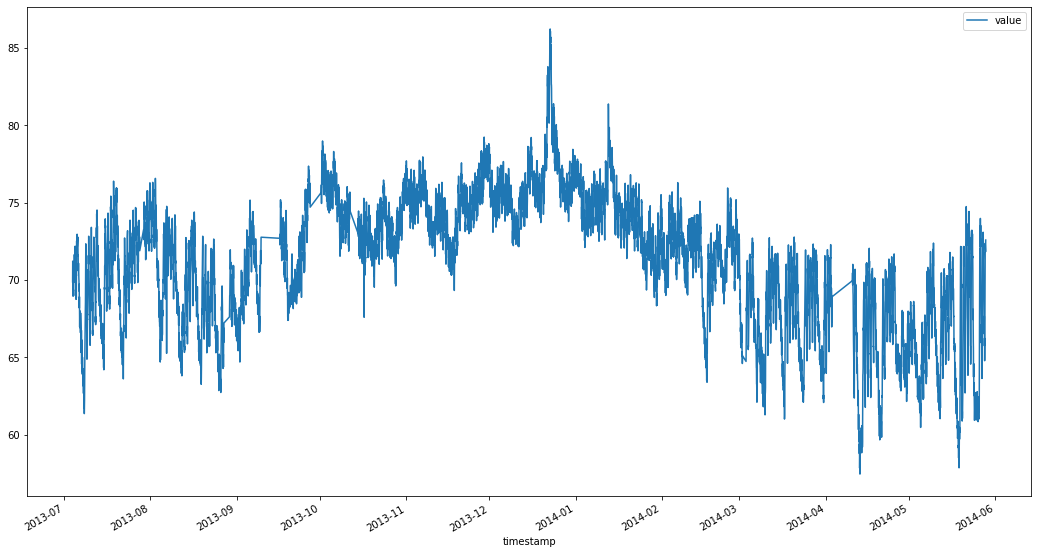

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(18, 10))

<AxesSubplot:>

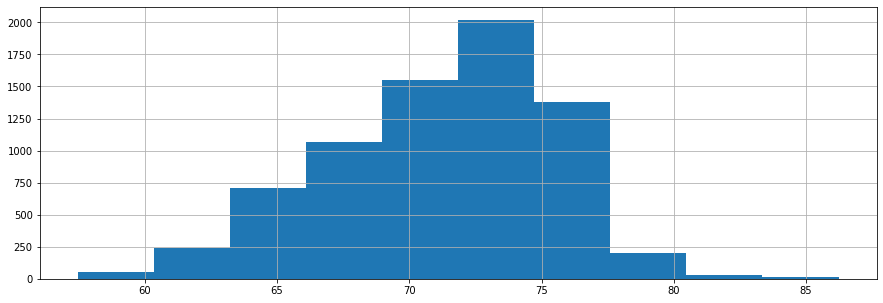

In [12]:
#histogram
data['value'].hist(figsize=(15,5))

In [23]:
data.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [5]:
def season(month):
    spring = (3, 4, 5)
    summer = (6, 7, 8)
    fall = (9, 10, 11)

    if month in spring:
        return 2 
    elif month in summer:
        return 3 
    elif month in fall:
        return 4 
    else:
        return 1 
    
data['hour'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['is_weekend'] = 0
data.loc[data['day_of_week'] == 5, 'is_weekend'] = 1
data.loc[data['day_of_week'] == 6, 'is_weekend'] = 1
data['daylight'] = ((data['hour'] >= 7) & (data['hour'] <= 22)).astype(int)
data['month'] = data['timestamp'].dt.month
data['season'] = data['timestamp'].dt.month.map(season)
data['year'] = data['timestamp'].dt.year
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)



In [31]:
data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,season,year,t
0,2013-07-04 00:00:00,69.880835,0.0,3,0,0,7,3,2013,13728960
1,2013-07-04 01:00:00,71.220227,1.0,3,0,0,7,3,2013,13728996
2,2013-07-04 02:00:00,70.877805,2.0,3,0,0,7,3,2013,13729032
3,2013-07-04 03:00:00,68.959400,3.0,3,0,0,7,3,2013,13729068
4,2013-07-04 04:00:00,69.283551,4.0,3,0,0,7,3,2013,13729104
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11.0,2,0,1,5,2,2014,14012748
7263,2014-05-28 12:00:00,72.172956,12.0,2,0,1,5,2,2014,14012784
7264,2014-05-28 13:00:00,72.046565,13.0,2,0,1,5,2,2014,14012820
7265,2014-05-28 14:00:00,71.825226,14.0,2,0,1,5,2,2014,14012856


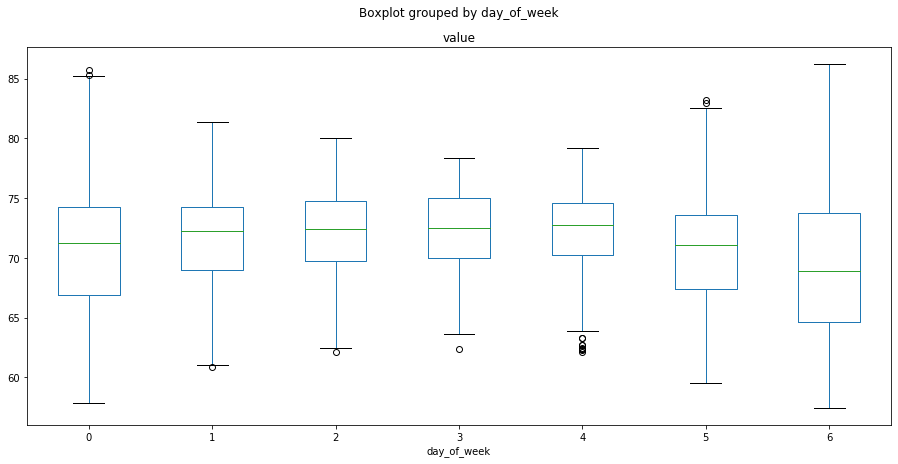

In [37]:
data.boxplot(by='day_of_week', column=['value'], grid=False, figsize=(15,7))

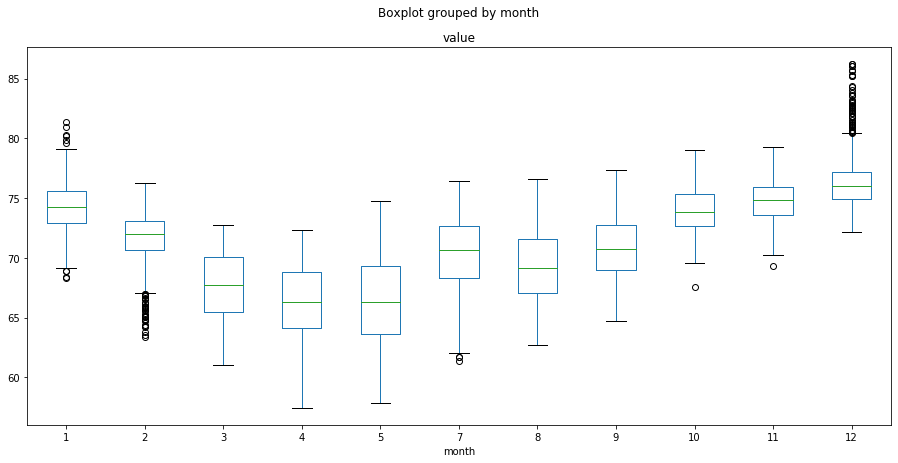

In [38]:
data.boxplot(by='month', column=['value'], grid=False, figsize=(15,7))

<BarContainer object of 11 artists>

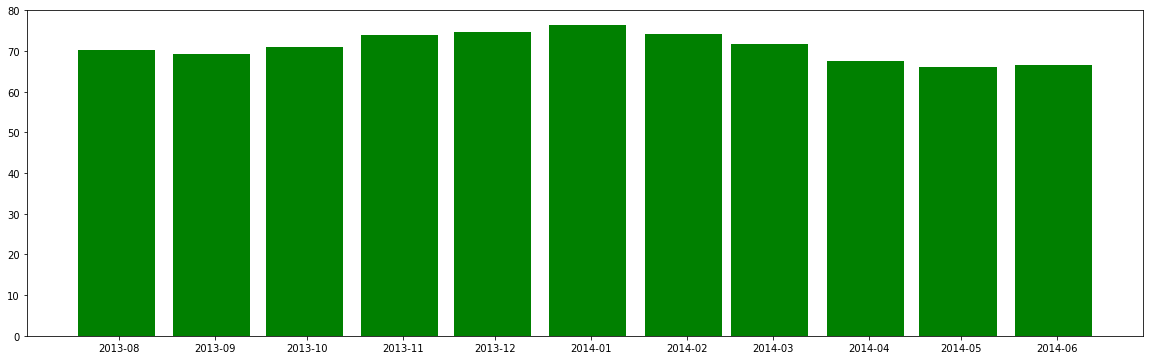

In [114]:
import matplotlib.dates as mdates
bar_d = pd.DataFrame(data=list(data['value']), index=list(data['timestamp']), columns=['value'])
df_month = bar_d.resample("M").mean()
#print(df_month)

fig, ax = plt.subplots(figsize=(20, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month.index, df_month.loc[:, "value"], width=25, align='center', color='g')

In [8]:
from sklearn.model_selection import train_test_split

tr_data, tst_data = train_test_split(data)
tr_data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,season,year,t
5253,2014-02-24 16:00:00,73.925927,16.0,0,0,1,2,1,2014,13932576
3144,2013-11-28 19:00:00,76.857315,19.0,3,0,1,11,4,2013,13856652
4665,2014-01-31 04:00:00,70.039279,4.0,4,0,0,1,1,2014,13911408
1824,2013-10-01 21:00:00,78.089981,21.0,1,0,1,10,4,2013,13806612
2742,2013-11-12 01:00:00,75.599126,1.0,1,0,0,11,4,2013,13842180
...,...,...,...,...,...,...,...,...,...,...
2612,2013-11-06 15:00:00,75.296571,15.0,2,0,1,11,4,2013,13837500
3904,2013-12-30 11:00:00,74.760678,11.0,0,0,1,12,1,2013,13884012
142,2013-07-09 22:00:00,69.175606,22.0,1,0,1,7,3,2013,13734072
2178,2013-10-19 13:00:00,71.753730,13.0,5,1,1,10,4,2013,13821876


In [12]:
#Missing Values

print('Number of missings by feature:\n',data.isnull().sum())

Number of missins by feature:
 timestamp      0
value          0
hour           0
day_of_week    0
is_weekend     0
daylight       0
month          0
year           0
t              0
dtype: int64


In [13]:
#Incorrect Values
from numpy import nan
i = 0
for row in data['value']:
    try:
        float(row)
    except ValueError:
        data.loc[cnt, 'value'] = nan
    i += 1
print(data.isnull().values.any())

False


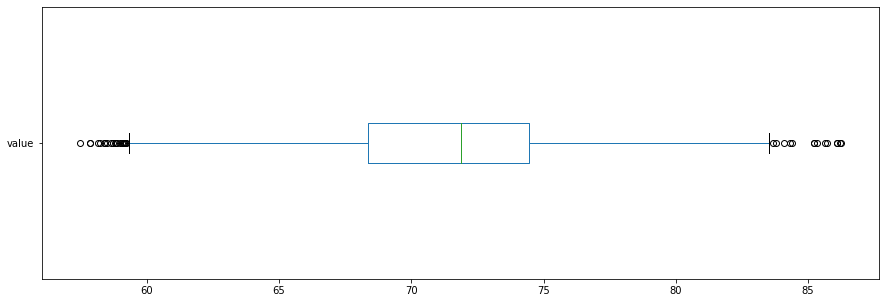

In [24]:
#Outliers
data['value'].plot.box(vert=False, figsize=(15,5))

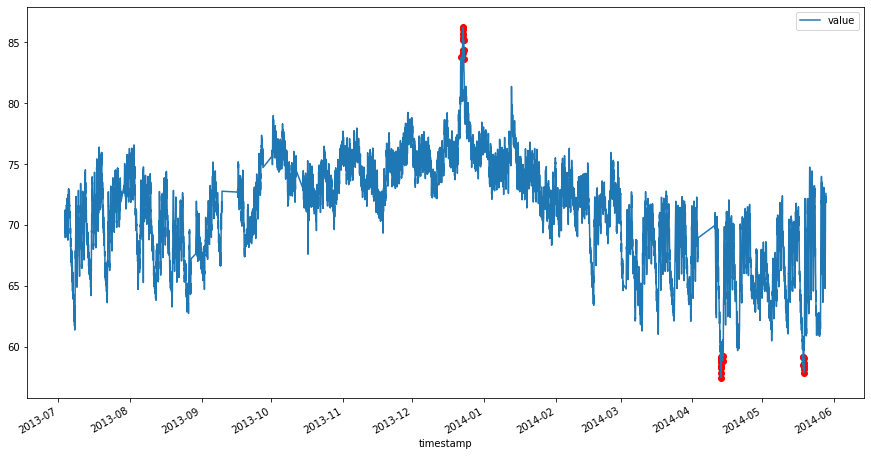

In [58]:
#find outliers
def detect_IQR(df,feature):
    q1 = df[feature].quantile(q=0.25)
    q3 = df[feature].quantile(q=0.75)
    IQR = q3-q1
    low= q1 - 1.5*IQR
    up = q3 + 1.5*IQR
    
    return low,up
low, up = detect_IQR(data,"value")

IQR_result=pd.DataFrame()
IQR_result['timestamp']=data['timestamp']
IQR_result['value'] = data['value']

#Inliers are labeled 1, while outliers are labeled -1.
IQR_result.loc[(IQR_result["value"]<low) | (IQR_result["value"]>up),"outlier"] = -1
IQR_result.loc[(IQR_result["value"]>=low) & (IQR_result["value"]<=up),"outlier"] = 1
i = IQR_result[IQR_result['outlier']==-1]
IQR_result.plot(x='timestamp', y='value', figsize=(15,8))

plt.scatter(x=i.timestamp, y=i.value, color='r')


In [6]:
from sklearn.preprocessing import LabelEncoder
cont_vars = ['value', 'hour', 't']
cat_vars = [  'is_weekend']
#encode the categorical data
label_encoders = [LabelEncoder() for _ in cat_vars]
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
    
data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,season,year,t
0,2013-07-04 00:00:00,69.880835,0.0,3,0,0,7,3,2013,13728960
1,2013-07-04 01:00:00,71.220227,1.0,3,0,0,7,3,2013,13728996
2,2013-07-04 02:00:00,70.877805,2.0,3,0,0,7,3,2013,13729032
3,2013-07-04 03:00:00,68.959400,3.0,3,0,0,7,3,2013,13729068
4,2013-07-04 04:00:00,69.283551,4.0,3,0,0,7,3,2013,13729104
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11.0,2,0,1,5,2,2014,14012748
7263,2014-05-28 12:00:00,72.172956,12.0,2,0,1,5,2,2014,14012784
7264,2014-05-28 13:00:00,72.046565,13.0,2,0,1,5,2,2014,14012820
7265,2014-05-28 14:00:00,71.825226,14.0,2,0,1,5,2,2014,14012856


In [7]:
#normalise the continuous variables
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
data_scaled = data.copy()
data_scaled[cont_vars] = scaler.fit_transform(data[cont_vars])
data_scaled

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,season,year,t
0,2013-07-04 00:00:00,-0.320586,-1.661537,3,0,0,7,3,2013,-1.755168
1,2013-07-04 01:00:00,-0.005228,-1.517172,3,0,0,7,3,2013,-1.754728
2,2013-07-04 02:00:00,-0.085851,-1.372807,3,0,0,7,3,2013,-1.754287
3,2013-07-04 03:00:00,-0.537536,-1.228442,3,0,0,7,3,2013,-1.753847
4,2013-07-04 04:00:00,-0.461215,-1.084077,3,0,0,7,3,2013,-1.753406
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.265532,-0.073523,2,0,1,5,2,2014,1.716225
7263,2014-05-28 12:00:00,0.219090,0.070841,2,0,1,5,2,2014,1.716665
7264,2014-05-28 13:00:00,0.189332,0.215206,2,0,1,5,2,2014,1.717105
7265,2014-05-28 14:00:00,0.137218,0.359571,2,0,1,5,2,2014,1.717546


[[ 8.67788289  4.28186928]
 [-8.0018297  -5.81067696]
 [-7.44367019  6.57468707]
 [ 8.82728363 -4.13678753]
 [ 0.43931069  4.83889194]
 [-8.67184532 -0.28061243]
 [ 3.82257812 -1.52343974]
 [-1.7696288  -3.37398688]]


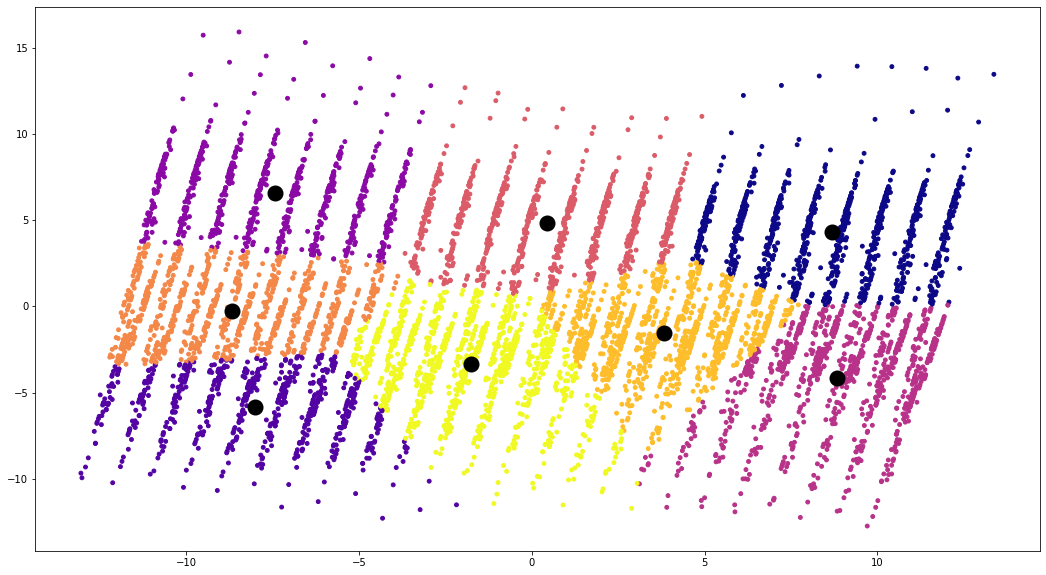

In [162]:
#Kmeans clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_clust = data.copy().loc[:,'value':'season']
data_clust.drop('t', axis=1, inplace=True)

model = KMeans(n_clusters=8, max_iter=100)

pca = PCA(n_components=2).fit(data_clust)
pca_2d = pca.transform(data_clust)

kmeans = model.fit(pca_2d)
labl = kmeans.predict(pca_2d)

#plt.plot(pca_2d[:,0], pca_2d[:,1])
plt.figure(figsize=(18,10))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labl, s=15, cmap='plasma')

centr = kmeans.cluster_centers_
plt.scatter(centr[:, 0], centr[:, 1], marker="o", s=169, linewidths=3, color="k")
#centr2d = pca.transform(centr)
print(centr)

<Figure size 1296x720 with 0 Axes>

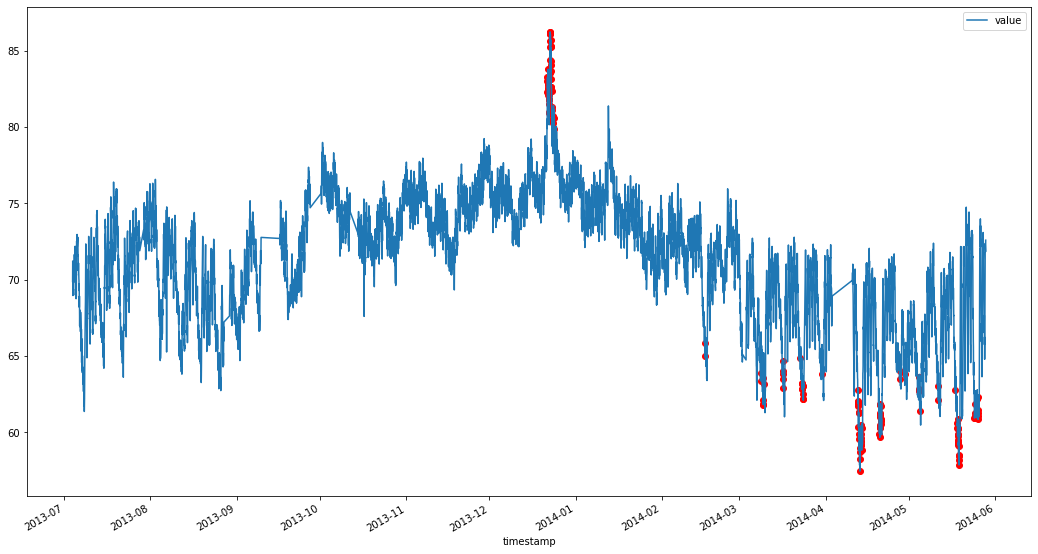

In [156]:
#outliers with kmeans clustering
clust_f = pd.DataFrame(pca_2d, columns=['feature1', 'feature2'])
clust_f['class'] = kmeans.labels_
import math

def distance(x, y):
    
    d1 = x[0] - y[0];
    d2 = x[1] - y[1];
    dist = math.sqrt(d1*d1 + d2*d2)
    return dist

def min_d(x):
    l=list()
    for i in centr:
        d = distance([clust_f.loc[x,'feature1'],clust_f.loc[x,'feature2']], i)
        l.append(d)
    m = min(l)
    return m

data_clust['distance'] = [min_d(x) for x in clust_f.index]
#data_clust['distance'] = [distance([clust_f.loc[x,'feature1'],clust_f.loc[x,'feature2']], centr[clust_f.loc[x,'class']]) for x in clust_f.index]
q = data_clust['distance'].quantile(q=0.98)
data_clust.loc[(data_clust["distance"]>q),"outlier"] = -1
data_clust.loc[(data_clust["distance"]<=q),"outlier"] = 1
data_clust['timestamp']=data['timestamp']
data_clust['value']=data['value']
c = data_clust[data_clust['outlier']==-1]

plt.figure(figsize=(18,10))
data.plot(x='timestamp', y='value', figsize=(18,10))
plt.scatter(x=c.timestamp, y=c.value, color='r')
#plt.scatter(data['timestamp'], data.value, c=colormap[get_outliers(clust_f)['class']], s=15)

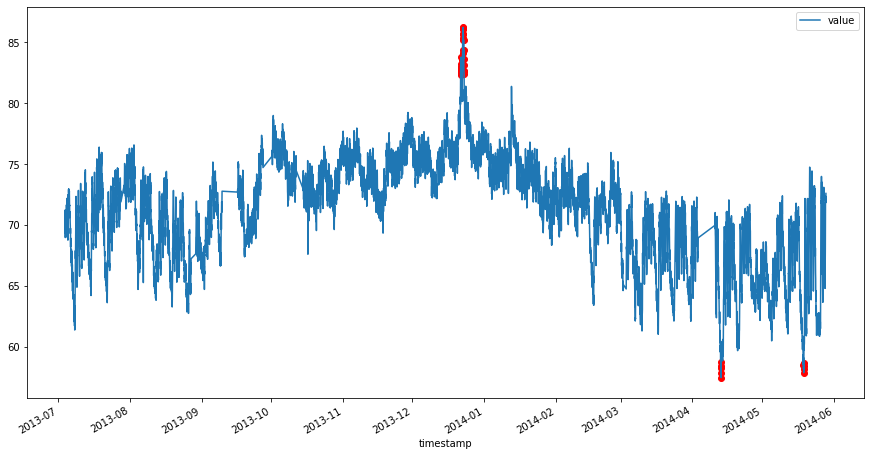

In [167]:
#isolation forest
from sklearn.ensemble import IsolationForest

iso=IsolationForest(contamination=0.005)
iso_result=iso.fit_predict(data['value'].values.reshape(-1,1))
iso_result_df=pd.DataFrame()
iso_result_df['timestamp']=data['timestamp']
iso_result_df['value'] = data['value']

#Inliers are labeled 1, while outliers are labeled -1.
iso_result_df['anomaly']  = [1 if i==-1 else 0 for i in iso_result]

iso_result_df.plot(x='timestamp', y='value', figsize=(15,8))

a=iso_result_df[iso_result_df['anomaly']==1]

plt.scatter(x=a.timestamp, y=a.value, color='r')

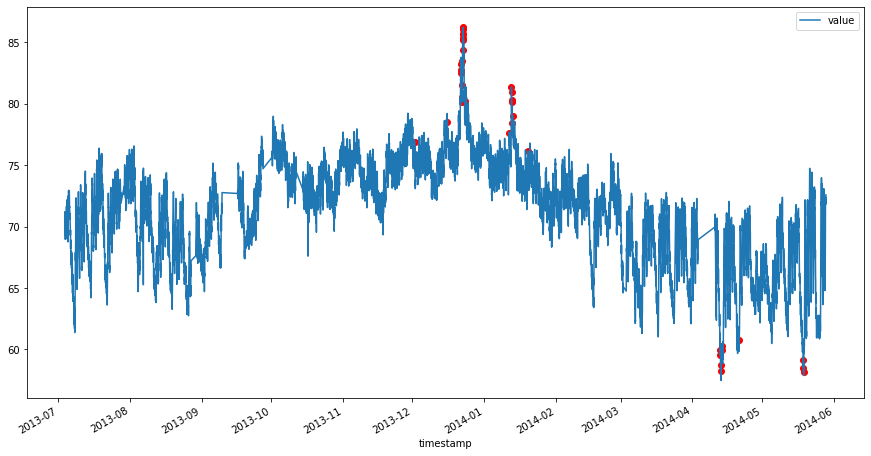

In [175]:
#Isolation Forest all features
X = data.copy().loc[:,'value':'month']
#X.drop('t', axis=1, inplace=True)
iso = iso.fit(X)

iso_all_df = X.copy()
iso_all_df['scores'] = iso.predict(X)
iso_all_df['timestamp'] = data['timestamp']
iso_all_df['anomaly'] = [0 if x>0 else 1 for x in iso_all_df['scores']]
e=iso_all_df[iso_all_df['anomaly']==1]

iso_all_df.plot(x='timestamp', y='value', figsize=(15,8))
plt.scatter(x=e.timestamp, y=e.value, color='r')

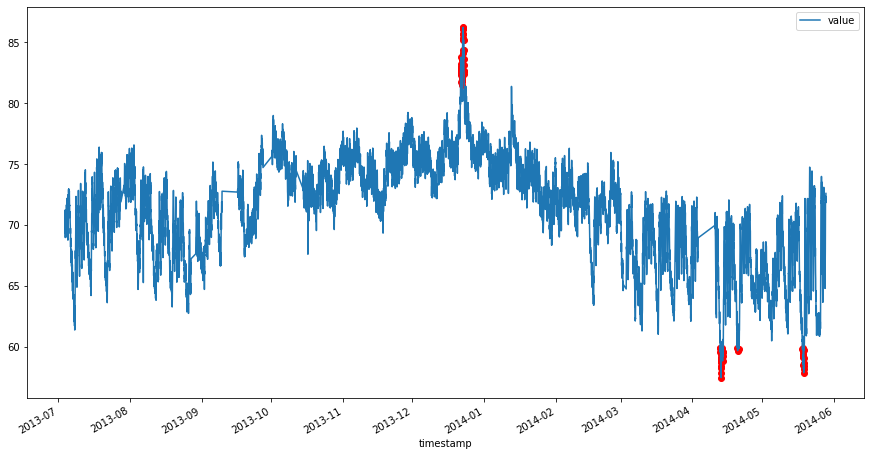

In [180]:
#One Class SVM 
from sklearn.svm import OneClassSVM

svm = OneClassSVM(nu=0.01, gamma=0.000001)
svm_result=svm.fit_predict(data['value'].values.reshape(-1,1))
svm_result_df=pd.DataFrame()
svm_result_df['timestamp']=data['timestamp']
svm_result_df['value'] = data['value']

#Inliers are labeled 1, while outliers are labeled -1.
svm_result_df['anomaly']  = [1 if i==-1 else 0 for i in svm_result]

svm_result_df.plot(x='timestamp', y='value', figsize=(15,8))

c=svm_result_df[svm_result_df['anomaly']==1]

plt.scatter(x=c.timestamp, y=c.value, color='r')

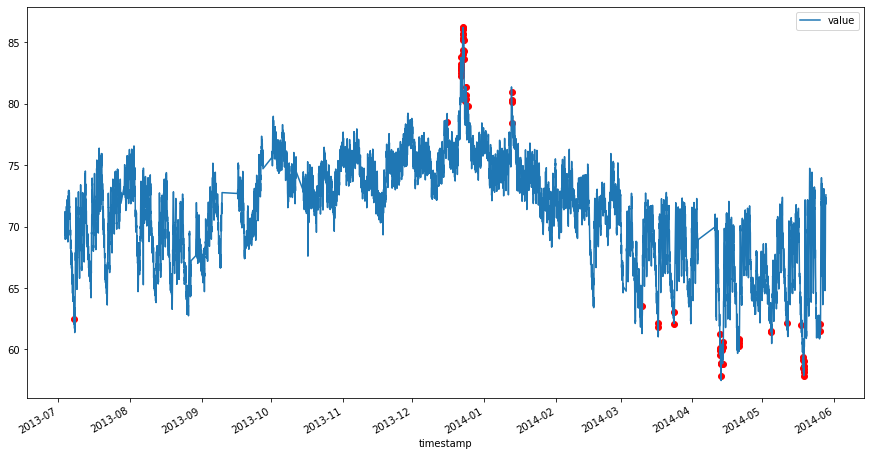

In [181]:
#One Class SVM all features
svm = svm.fit(X)

svm_all_df = X.copy()
svm_all_df['scores'] = svm.predict(X)
svm_all_df['timestamp'] = data['timestamp']
svm_all_df['anomaly'] = [0 if x>0 else 1 for x in svm_all_df['scores']]
e=svm_all_df[svm_all_df['anomaly']==1]

svm_all_df.plot(x='timestamp', y='value', figsize=(15,8))
plt.scatter(x=e.timestamp, y=e.value, color='r')

In [ ]:
'Gaussian tests'

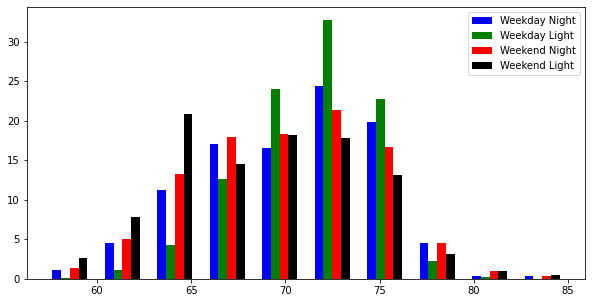

In [153]:
#Gaussian tests
data['categories'] = data['is_weekend']*2 + data['daylight']
a = data.loc[data['categories'] == 0, 'value']
b = data.loc[data['categories'] == 1, 'value']
c = data.loc[data['categories'] == 2, 'value']
d = data.loc[data['categories'] == 3, 'value']

figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekday Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekday Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekend Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekend Light')
plt.legend()
plt.show()


[Text(0.5, 1.0, 'Frequency Histogram weekday night'),
 Text(0, 0.5, 'Frequency')]

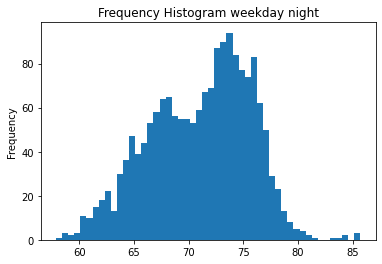

In [203]:
plt.hist(data.loc[data['categories']== 0]['value'],bins=50)
plt.gca().set(title="Frequency Histogram weekday night", ylabel='Frequency')

[Text(0.5, 1.0, 'Frequency Histogram weekday light'),
 Text(0, 0.5, 'Frequency')]

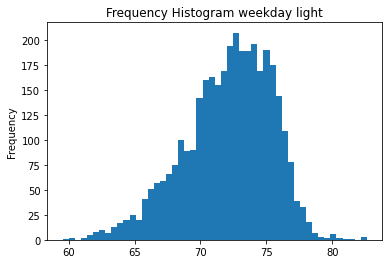

In [204]:
plt.hist(data.loc[data['categories']== 1]['value'],bins=50)
plt.gca().set(title="Frequency Histogram weekday light", ylabel='Frequency')

[Text(0.5, 1.0, 'Frequency Histogram weekend night'),
 Text(0, 0.5, 'Frequency')]

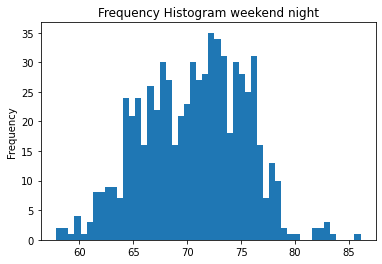

In [205]:
plt.hist(data.loc[data['categories']== 2]['value'],bins=50)
plt.gca().set(title="Frequency Histogram weekend night", ylabel='Frequency')

[Text(0.5, 1.0, 'Frequency Histogram weekend light'),
 Text(0, 0.5, 'Frequency')]

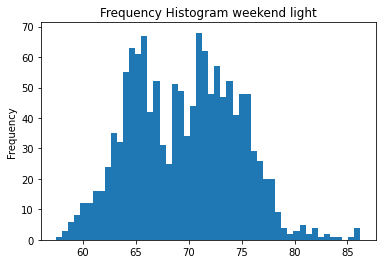

In [206]:
plt.hist(data.loc[data['categories']== 3]['value'],bins=50)
plt.gca().set(title="Frequency Histogram weekend light", ylabel='Frequency')

In [171]:
from sklearn.covariance import EllipticEnvelope

elen = EllipticEnvelope(contamination = 0.01)
day_n = data.loc[data['categories'] == 0, 'value':'year']
el = elen.fit(day_n)
res_1 = el.predict(day_n)
day_d = data.loc[data['categories'] == 1, 'value':'year']
res_2 = el.predict(day_d)
end_n = data.loc[data['categories'] == 2, 'value':'year']
res_3 = el.predict(end_n)
end_d = data.loc[data['categories'] == 3, 'value':'year']
res_4 = el.predict(end_d)
gauss = data.copy()
gauss.loc[gauss['categories'] == 0, 'anomaly'] = res_1
gauss.loc[gauss['categories'] == 1, 'anomaly'] = res_2
gauss.loc[gauss['categories'] == 2, 'anomaly'] = res_3
gauss.loc[gauss['categories'] == 3, 'anomaly'] = res_4
gauss

c:\users\annas\appdata\local\programs\python\python37\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning:

The covariance matrix associated to your dataset is not full rank



,timestamp,value,hour,day_of_week,is_weekend,daylight,month,season,year,t,anomaly27,categories,anomaly
0,2013-07-04 00:00:00,69.880835,0.0,3,0,0,7,3,2013,13728960,0,0,1.0
1,2013-07-04 01:00:00,71.220227,1.0,3,0,0,7,3,2013,13728996,0,0,1.0
2,2013-07-04 02:00:00,70.877805,2.0,3,0,0,7,3,2013,13729032,0,0,1.0
3,2013-07-04 03:00:00,68.959400,3.0,3,0,0,7,3,2013,13729068,0,0,1.0
4,2013-07-04 04:00:00,69.283551,4.0,3,0,0,7,3,2013,13729104,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11.0,2,0,1,5,2,2014,14012748,1,1,1.0
7263,2014-05-28 12:00:00,72.172956,12.0,2,0,1,5,2,2014,14012784,0,1,1.0
7264,2014-05-28 13:00:00,72.046565,13.0,2,0,1,5,2,2014,14012820,0,1,1.0
7265,2014-05-28 14:00:00,71.825226,14.0,2,0,1,5,2,2014,14012856,0,1,1.0


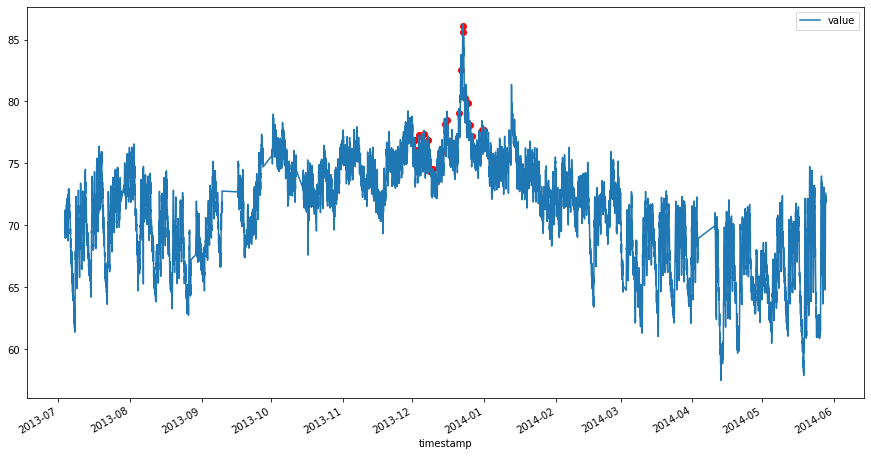

In [172]:
#Gauss anomalies visualisation
e=gauss[gauss['anomaly']==-1]

gauss.plot(x='timestamp', y='value', figsize=(15,8))
plt.scatter(x=e.timestamp, y=e.value, color='r')

In [ ]:
'RNN model'

In [138]:
from sklearn import preprocessing

data_n = data.copy()
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(data[['value']])
data_n['value'] = scaler.transform(data_n[['value']])

prediction_time = 1 
testdatasize = 2500
unroll_length = 24*7
testdatacut = testdatasize + unroll_length  + 1

#Training data
train = data_n[0:-prediction_time-testdatacut]

#Test data
test = data_n[0-testdatacut:-prediction_time]
test.shape

(2668, 11)

In [141]:

TIME_STEPS=24*7

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')
y_train

Training shape: (4429, 168, 1)
Testing shape: (2500, 168, 1)


array([-0.51469712, -0.4617722 , -0.76125637, ...,  0.20922586,
       -0.22014653,  0.01297278])

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 168, 128)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 168, 128)          131584    
_________________________________________________________________
dropout_41 (Dropout)         (None, 168, 128)          0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 168, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

In [199]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
125/125 [==============================] - 31s 225ms/step - loss: 0.1446 - val_loss: 0.0483
Epoch 2/100
125/125 [==============================] - 25s 203ms/step - loss: 0.0690 - val_loss: 0.0513
Epoch 3/100
125/125 [==============================] - 26s 205ms/step - loss: 0.0573 - val_loss: 0.0449
Epoch 4/100
125/125 [==============================] - 26s 206ms/step - loss: 0.0473 - val_loss: 0.0375
Epoch 5/100
125/125 [==============================] - 26s 206ms/step - loss: 0.0450 - val_loss: 0.0350
Epoch 6/100
125/125 [==============================] - 26s 211ms/step - loss: 0.0460 - val_loss: 0.0335
Epoch 7/100
125/125 [==============================] - 27s 212ms/step - loss: 0.0458 - val_loss: 0.0331
Epoch 8/100
125/125 [==============================] - 27s 212ms/step - loss: 0.0442 - val_loss: 0.0336
Epoch 9/100
125/125 [==============================] - 27s 212ms/step - loss: 0.0439 - val_loss: 0.0332
Epoch 10/100
125/125 [==============================] - 27s 217m

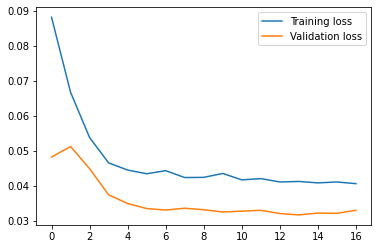

In [200]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

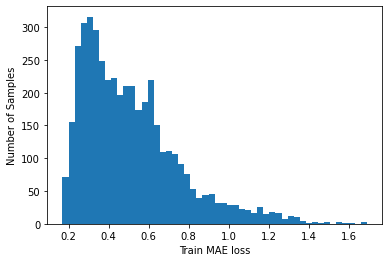

In [207]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)

Text(0, 0.5, 'Number of samples')

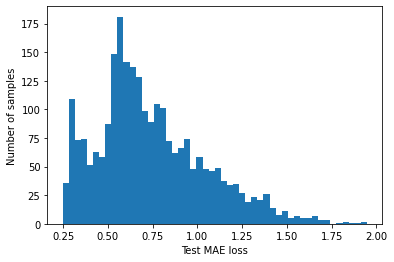

In [208]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

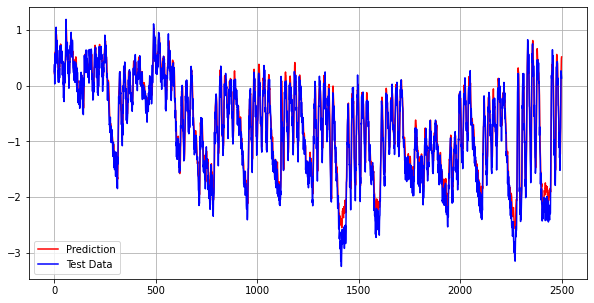

In [194]:
plt.figure(figsize = (10, 5))
plt.plot(X_test_pred,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [187]:
X_test_pred[:,0].shape

(2500, 1)

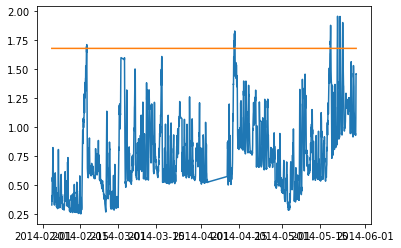

In [147]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']


plt.plot(test_score_df['timestamp'], test_score_df['loss'])
plt.plot(test_score_df['timestamp'], test_score_df['threshold'])


In [148]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(30, 14)

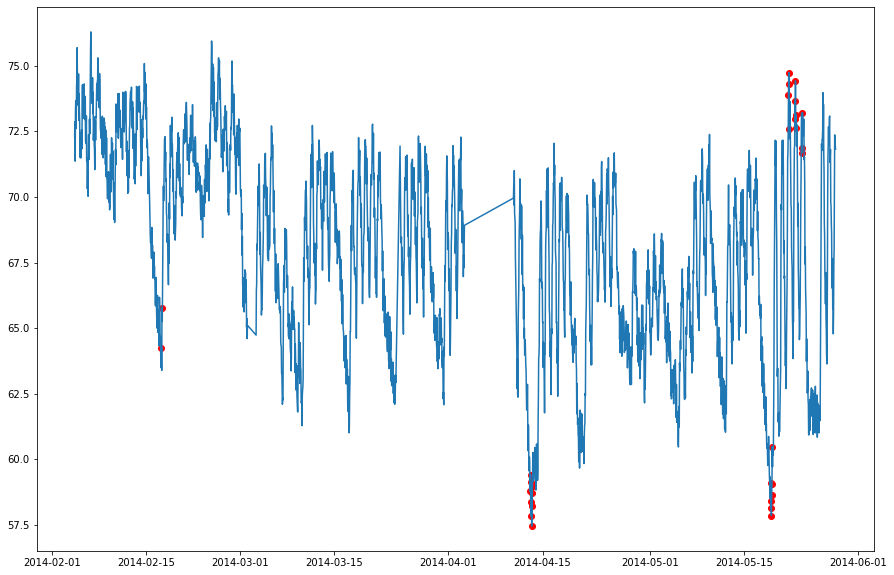

In [149]:
plt.figure(figsize=(15,10))
plt.plot(test_score_df['timestamp'], scaler.inverse_transform(test_score_df['value']))
plt.scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['value']), color = 'r')
